# Introduction to pjit

This guide explains how to use pjit to compile and automatically partition functions in both single and multi-host environments. `Pjit` is `jit` with `in_axis_resources` and `out_axis_resources` to specify how a function should be partitioned. `Pjit` can be useful when the jitted version of fun would not fit in a single device’s memory, or to speed up fun by running each operation in parallel across multiple devices. `Pjit` enables users to shard computations without rewriting using the SPMD partitioner. The returned function has semantics equivalent to those of `fun`, but is compiled to an XLA computation that runs across multiple devices (e.g. multiple GPUs or multiple TPU cores). 

Two examples are shown in this guide to demonstrate how pjit works in both single and multi-host environments. The identity function (`lambda x: x`) is chosen to better show how other input parameters are used. 


```python
jax.experimental.pjit.pjit(fun, in_axis_resources, out_axis_resources, static_argnums=(), donate_argnums=())
```

## Background 
The core infrastructure that supports parallel model training is the XLA SPMD partitioner. It takes in an XLA program that represents the complete neural net, as if there is only one giant virtual device. In addition to the program, it also takes in partitioning specifications for both function inputs and outputs. The output of the XLA SPMD partitioner is an identical program for N devices that performs communications between devices through collective operations. The program only compiles once per host. **Pjit is the API exposed for the XLA SPMD partitioner in JAX.**

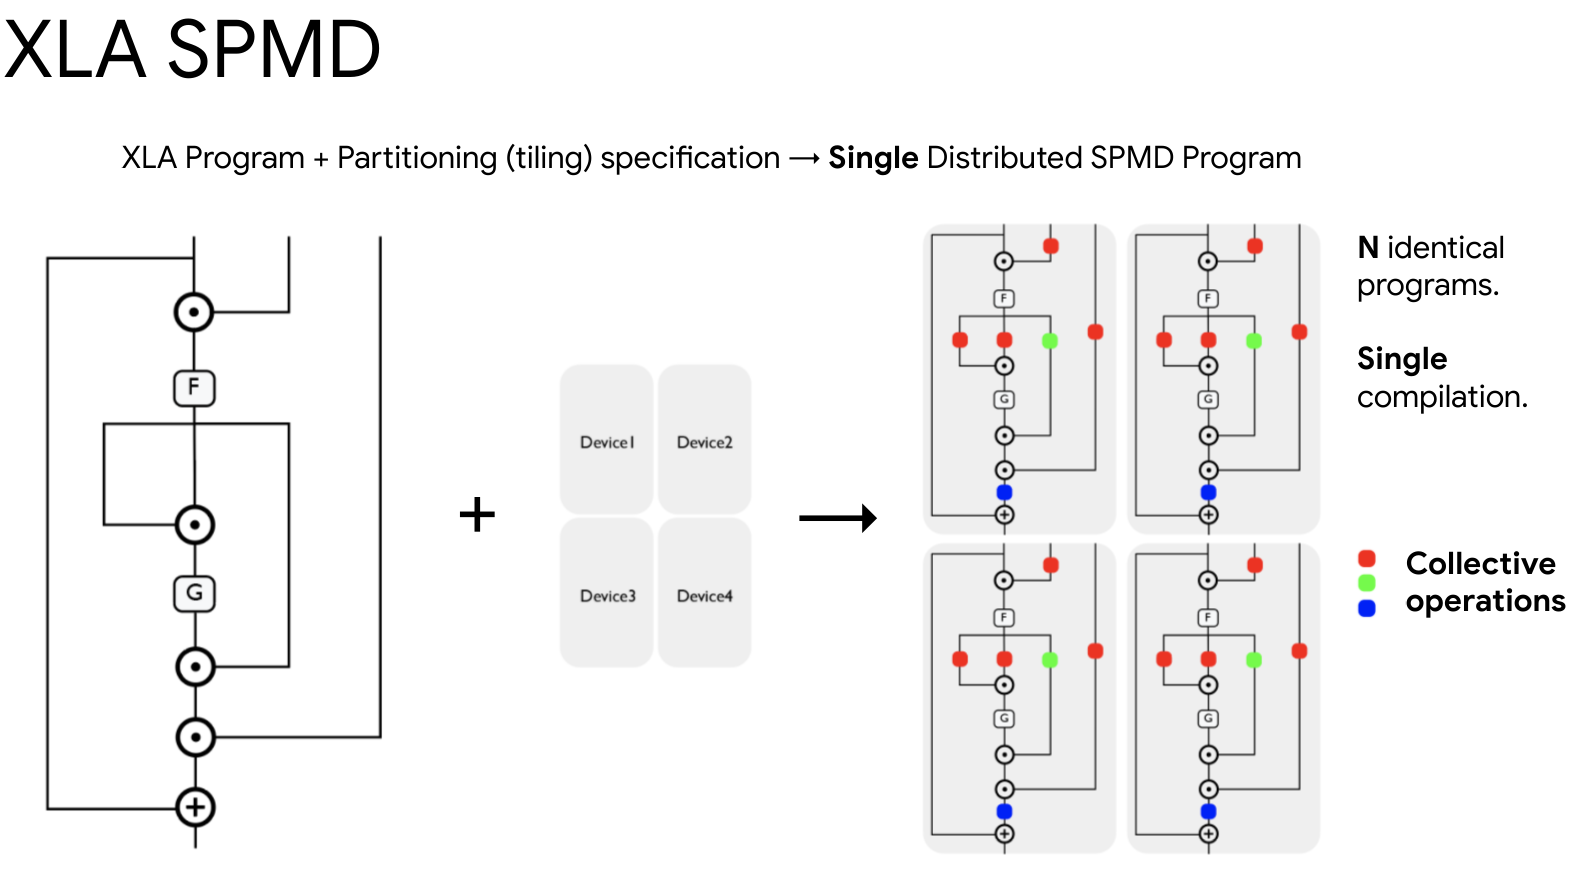

## How it works:
The partitioning over devices happens automatically based on the propagation of the input partitioning specified in `in_axis_resources` and the output partitioning specified in `out_axis_resources`. The resources specified in those two arguments must refer to `mesh axes`, as defined by the `jax.experimental.maps.mesh()` context manager. Note that the `mesh` definition at `pjit` application time is ignored, and the returned function will use the `mesh` definition available at each call site.

Inputs to a pjit’d function will be automatically partitioned across devices if they’re not already correctly partitioned based on `in_axis_resources`. In some scenarios, ensuring that the inputs are already correctly pre-partitioned can increase performance. For example, if passing the output of one pjit’d function to another pjit’d function (or the same pjit’d function in a loop), make sure the relevant `out_axis_resources` match the corresponding `in_axis_resources`.

# Single Host Example

In this example, we have 
- `mesh`: a mesh of shape (4, 2) and axes named ‘x’ and ‘y’ respectively. 
- `input data`: an 8 by 2 numpy array. 
- `in_axis_resources`: None. So the (8, 2) input data is replicated across all devices.
- `out_axis_resources`: PartitionSpec('x', 'y'). It specifies that the two dimensions of output data are sharded over `x` and `y` respectively. 
- `function`: `lambda x: x`. It is the identity function.

As a result, the pjit’d function applied with the given mesh replicates the input across all devices based on `in_axis_resources`, and then keeps only what each device should have based on `out_axis_resources`. It effectively shards the data on CPU across all accelerators according to the `PartitionSpec`. 

Each parameter is explained in detail below:

## Setup

This tutorial should be run on TPU with 8 devices. Please [build your own runtime](https://cloud.google.com/tpu/docs/jax-pods) on Google Cloud Platform and [connects to it using Jupyter](https://research.google.com/colaboratory/local-runtimes.html).

In [2]:
import jax
from jax.experimental import maps
from jax.experimental import PartitionSpec
from jax.experimental.pjit import pjit
import numpy as np

## Mesh
Mesh is defined in [jax/interpreters/pxla](https://github.com/google/jax/blob/main/jax/interpreters/pxla.py#L1389), and it is a numpy array of jax devices in a multi-dimensional grid, alongside names for the axes of this mesh. It is also called the logical mesh.

In the example we are working with, the first (vertical) axis is named ‘x’ and has length 4, and the second (horizontal) axis is named ‘y’ and has length 2. If a dimension of data is sharded across an axis, each device has a slice of the size of data.shape[dim] divided by mesh_shape[axis]. If data is replicated across an axis, devices on that axis should have the same data.

In [3]:
mesh_shape = (4, 2)
devices = np.asarray(jax.devices()).reshape(*mesh_shape)
# 'x', 'y' axis names are used here for simplicity
mesh = maps.Mesh(devices, ('x', 'y'))
mesh

Mesh(array([[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
        TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1)],
       [TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
        TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1)],
       [TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
        TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1)],
       [TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
        TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]],
      dtype=object), ('x', 'y'))

The actual TPU physical device mesh are connected by Inter-chip Interconnect (ICI) fabric. The logical mesh with given axis names is created to abstract the physical device mesh because it is easier to reshape the logical mesh based on distributed computation needs. The layout of the logical mesh is different from that of the physical mesh.

For example, we can have a physical mesh of size (4, 4, 4). If the computation requires a 16-way data parallelism and 4-way model parallelism, the physical mesh should be abstracted to a logical mesh with a shape of (16, 4).

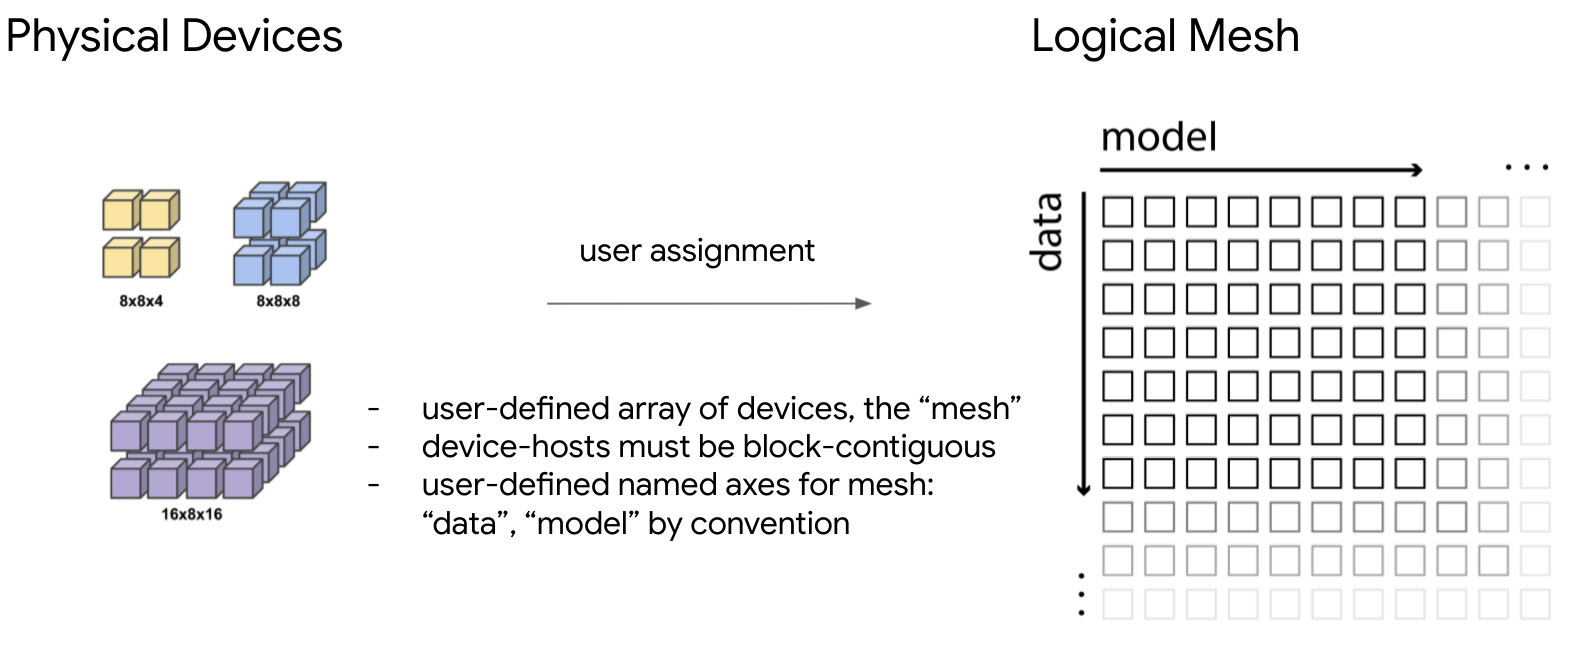

## Input Data
A numpy array of size (8,2)

In [4]:
input_data = np.arange(8 * 2).reshape(8, 2)
input_data

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15]])

## in_axis_resources & out_axis_resources
Pytree of structure matching that of arguments to fun, with all actual arguments replaced by resource assignment specifications. It is also valid to specify a pytree prefix (e.g. one value in place of a whole subtree), in which case the leaves get broadcast to all values in that subtree.

The valid resource assignment specifications are:
- None, in which case the value will be replicated on all devices 
- PartitionSpec, a tuple of length at most equal to the rank of the partitioned value. Each element can be a None, a mesh axis or a tuple of mesh axes, and specifies the set of resources assigned to partition the value’s dimension matching its position in the spec. More details are discussed in the section below (More information on PartitionSpec). 

The size of every dimension has to be a multiple of the total number of resources assigned to it.

out_axis_resources – Like in_axis_resources, but specifies resource assignment for function outputs.

In [5]:
in_axis_resources=None
out_axis_resources=PartitionSpec('x', 'y')

## Putting everything together

In [6]:
f = pjit(
  lambda x: x,
  in_axis_resources=None,
  out_axis_resources=PartitionSpec('x', 'y'))
 
# Sends data to accelerators based on partition_spec
with maps.mesh(mesh.devices, mesh.axis_names):
 data = f(input_data)

In [7]:
data

ShardedDeviceArray([[ 0,  1],
                    [ 2,  3],
                    [ 4,  5],
                    [ 6,  7],
                    [ 8,  9],
                    [10, 11],
                    [12, 13],
                    [14, 15]], dtype=int32)

In [8]:
data.device_buffers

[DeviceArray([[0],
              [2]], dtype=int32), DeviceArray([[1],
              [3]], dtype=int32), DeviceArray([[4],
              [6]], dtype=int32), DeviceArray([[5],
              [7]], dtype=int32), DeviceArray([[ 8],
              [10]], dtype=int32), DeviceArray([[ 9],
              [11]], dtype=int32), DeviceArray([[12],
              [14]], dtype=int32), DeviceArray([[13],
              [15]], dtype=int32)]

The result after applying the pjit’d function is a  ShardedDeviceArray, and device_buffers show what data each device has.

**Result visualization:** 
Each color represents a different device. Since an (8,2) array is partitioned across a (4,2) mesh in both ‘x’ and ‘y’ axes, each accelerator ends up with a (2,1) slice of the data.

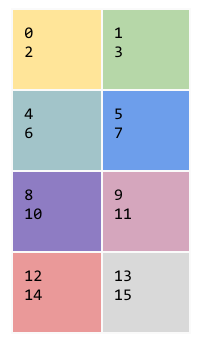

### More information on PartitionSpec:

PartitionSpec is a named tuple, whose element can be a None, a mesh axis or a tuple of mesh axes. Each element describes which mesh dimension the input’s dimension is partitioned across. For example, `PartitionSpec(“x”, “y”)` is a PartitionSpec where the first dimension of data is sharded across `x` axis of the mesh, and the second dimension is sharded across `y` axis of the mesh.

**Examples of other possible PartitionSpecs:**

Reminder: mesh is of shape (4, 2), input data is of shape (8, 2) 

### **- `PartitionSpec(“x”, None)`**

In [9]:
f = pjit(
  lambda x: x,
  in_axis_resources=None,
  out_axis_resources=PartitionSpec('x', None))
 
with maps.mesh(mesh.devices, mesh.axis_names):
 data = f(input_data)

data.device_buffers

[DeviceArray([[0, 1],
              [2, 3]], dtype=int32), DeviceArray([[0, 1],
              [2, 3]], dtype=int32), DeviceArray([[4, 5],
              [6, 7]], dtype=int32), DeviceArray([[4, 5],
              [6, 7]], dtype=int32), DeviceArray([[ 8,  9],
              [10, 11]], dtype=int32), DeviceArray([[ 8,  9],
              [10, 11]], dtype=int32), DeviceArray([[12, 13],
              [14, 15]], dtype=int32), DeviceArray([[12, 13],
              [14, 15]], dtype=int32)]

the first dimension of the input is sharded across `x` axis and the other dimensions are replicated across other axes. `None` can also be omitted in the PartitionSpec. If `out_axis_resources = PartitionSpec(“x”, None)` in the example above, the result visualization will be the following:

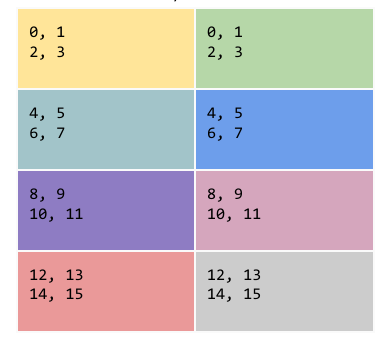

### **- `PartitionSpec(“y”, None)`**

In [10]:
f = pjit(
  lambda x: x,
  in_axis_resources=None,
  out_axis_resources=PartitionSpec('y', None))
 
with maps.mesh(mesh.devices, mesh.axis_names):
 data = f(input_data)

data.device_buffers

[DeviceArray([[0, 1],
              [2, 3],
              [4, 5],
              [6, 7]], dtype=int32), DeviceArray([[ 8,  9],
              [10, 11],
              [12, 13],
              [14, 15]], dtype=int32), DeviceArray([[0, 1],
              [2, 3],
              [4, 5],
              [6, 7]], dtype=int32), DeviceArray([[ 8,  9],
              [10, 11],
              [12, 13],
              [14, 15]], dtype=int32), DeviceArray([[0, 1],
              [2, 3],
              [4, 5],
              [6, 7]], dtype=int32), DeviceArray([[ 8,  9],
              [10, 11],
              [12, 13],
              [14, 15]], dtype=int32), DeviceArray([[0, 1],
              [2, 3],
              [4, 5],
              [6, 7]], dtype=int32), DeviceArray([[ 8,  9],
              [10, 11],
              [12, 13],
              [14, 15]], dtype=int32)]

the first dimension of the input is sharded across `y` axis and the other dimensions are replicated across other axes. If `out_axis_resources = PartitionSpec(“y”, None)` in the example above, the result visualization will be the following: 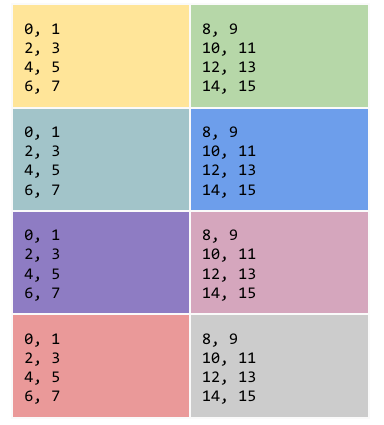

### **- `PartitionSpec((“x”, “y”), None)`**

In [11]:
f = pjit(
  lambda x: x,
  in_axis_resources=None,
  out_axis_resources=PartitionSpec(('x', 'y'), None))
 
with maps.mesh(mesh.devices, mesh.axis_names):
 data = f(input_data)

data.device_buffers

[DeviceArray([[0, 1]], dtype=int32),
 DeviceArray([[2, 3]], dtype=int32),
 DeviceArray([[4, 5]], dtype=int32),
 DeviceArray([[6, 7]], dtype=int32),
 DeviceArray([[8, 9]], dtype=int32),
 DeviceArray([[10, 11]], dtype=int32),
 DeviceArray([[12, 13]], dtype=int32),
 DeviceArray([[14, 15]], dtype=int32)]

the first dimension of the input is sharded across both `x` and `y` axis and the other dimensions are replicated across other axes. We can think of this as stretching the 2D mesh into an 1D mesh and then do the partition. If `out_axis_resources = PartitionSpec((“x”, “y”), None)` in the example above, the result visualization will be the following: 
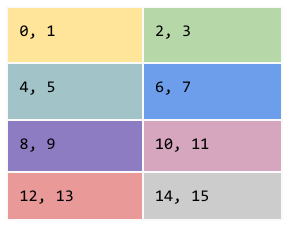

### **- `PartitionSpec(None, 'y')`**

In [12]:
f = pjit(
  lambda x: x,
  in_axis_resources=None,
  out_axis_resources=PartitionSpec(None, 'y'))
 
with maps.mesh(mesh.devices, mesh.axis_names):
 data = f(input_data)

data.device_buffers

[DeviceArray([[ 0],
              [ 2],
              [ 4],
              [ 6],
              [ 8],
              [10],
              [12],
              [14]], dtype=int32), DeviceArray([[ 1],
              [ 3],
              [ 5],
              [ 7],
              [ 9],
              [11],
              [13],
              [15]], dtype=int32), DeviceArray([[ 0],
              [ 2],
              [ 4],
              [ 6],
              [ 8],
              [10],
              [12],
              [14]], dtype=int32), DeviceArray([[ 1],
              [ 3],
              [ 5],
              [ 7],
              [ 9],
              [11],
              [13],
              [15]], dtype=int32), DeviceArray([[ 0],
              [ 2],
              [ 4],
              [ 6],
              [ 8],
              [10],
              [12],
              [14]], dtype=int32), DeviceArray([[ 1],
              [ 3],
              [ 5],
              [ 7],
              [ 9],
              [11],
          

the second dimension of the input is sharded over y axis and the first dimensions is replicated across other axes. We can think of this as stretching the 2D mesh into an 1D mesh and then do the partition. If out_axis_resources = PartitionSpec(None, 'y') in the example above, the result visualization will be the following:

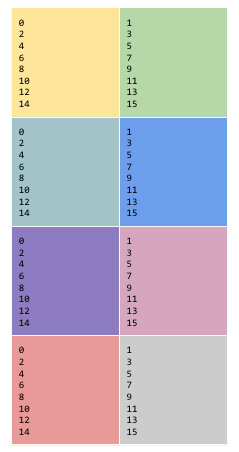

### **- `PartitionSpec(None, 'x')`**

`pjit` will complain when `out_axis_resources` is set to be `PartitionSpec(None, 'x')`. This is because the second dimension of input data is of size 2, but mesh's `x` dimension has size 4. size 2 can not be sharded over size 4. It is important to note that the size of input data has to be divisible by the size of mesh on corresponding dimensions.

# Multiple Host Example

The following example is run in parallel on each host in a Cloud TPU v3-32 pod slice (4 hosts 32 devices). ([Set up instruction here](https://cloud.google.com/tpu/docs/jax-pods))

In this example, we have 

- `mesh`: a mesh of shape (16, 2) and axes named ‘x’ and ‘y’ respectively. 
- `input data`: Each host contains a quarter (8, 2) of the input data of size (32, 2).
- `in_axis_resources`: PartitionSpec(('x', 'y'),). This lets `pjit` know that the (32, 2) input data is already split evenly across hosts (done by user). 
- `out_axis_resources`: PartitionSpec('x', 'y'). It specifies that the two dimensions of output data are sharded over `x` and `y` respectively.
- `function`: `lambda x: x`. It is the identity function.

The pjit’d function applied with a given mesh distributes an even slice to each device. It effectively shards the data on hosts across all accelerators based on the PartitionSpec.

## Setup
```python
import jax
from jax.experimental import maps
from jax.experimental import PartitionSpec
from jax.experimental.pjit import pjit
from jax.interpreters import pxla
import numpy as np
```

## Mesh

In this example, there are 4 hosts with 32 devices. These physical devices are abstracted to a logical mesh of size (16, 2). The first (vertical) axis is named ‘x’ and has length 16, and the second (horizontal) axis is named ‘y’ and has length 2. Within the global mesh, the first (4, 2) devices are connected to host 0, the second (4, 2) devices are connected to host 1. The first 8 devices (in the order of left to right, top to bottom) always belong to host 0, and the second 8 devices always belong to host 1 and so on. 


```python
mesh_shape = (16, 2)
devices = np.asarray(jax.devices()).reshape(*mesh_shape)
mesh = maps.Mesh(devices, ('x', 'y'))
```

## Input data

In a multi-host environment, all the devices connected to one host have to contain a subslice of a single continuous large slice of the data. In JAX SPMD, there are no direct communications between hosts, so hosts only talk to each other via collective communication between devices. As a result, users need to handle distributed data loading on hosts. 

In this example, the input array of size (32,2) is manually split into quarters of size (8,2) along the `x` axis by user and assigned to each host.

```python
if jax.process_index() == 0:
 input_data = np.arange(0,16).reshape(8,2)
elif jax.process_index() == 1:
 input_data = np.arange(16,32).reshape(8,2)
elif jax.process_index() == 2:
 input_data = np.arange(32,48).reshape(8,2)
else:
 input_data = np.arange(48,64).reshape(8,2)
```

## in_axis_resources & out_axis_resources

- `in_axis_resources`: PartitionSpec(('x', 'y'),). This partitions the first dimension of input data over both `x` and `y` axes. This lets Pjit know that the (32, 2) input data is already split evenly across hosts (done by user). Since input argument dimensions partitioned over multi-process mesh axes should be of size equal to the corresponding local mesh axis size, pjit sends the (8, 2) on each host to its devices based on `in_axis_resources`. Since each host has a logical mesh of size (4, 2) within the entire logical mesh, each device has a (1, 2) slice. 
- `out_axis_resources`: PartitionSpec('x', 'y'). It specifies that the two dimensions of output data are sharded over `x` and `y` respectively, so each device gets a (2,1) slice. 

**Note**: in_axis_resources and out_axis_resources are different. Here, in_axis_resources shards input data's first dimension over both `x` and `y`, whereas out_axis_resources shards input data's first dimension only over `x`.

## Putting everything together
```python
f = pjit(
   lambda x: x,
   in_axis_resources=PartitionSpec(('x', 'y'),),
   out_axis_resources=PartitionSpec('x', 'y'))

# Sends data to accelerators based on partition_spec
with maps.mesh(mesh.devices, mesh.axis_names):
 data = f(input_data)
```

**Result on host 0**

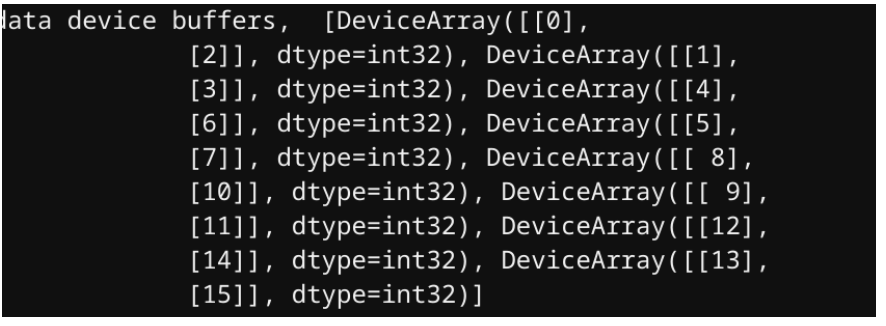